Case 1: The A.I. crypto trader - Make a prediction model of the major cryptocurrencies’ prices and an autonomous A.I. decision-maker for trading/investing
Data from: https://www.kaggle.com/bizzyvinci/coinmarketcap-historical-data

Authors:

Desislava Nikolova

Marin Stoyanov

In order to simplify the task on hand, we decided to look at only one cryptocurrency. We chose Ethereum as a famous coin and at the same time it is not the most common one. In coins.csv file, the abbreviation of the coins is in the column "symbol". We use this column to find "ETH" and specifically its "id". The "id" corresponds to the "coin_id" in the file historical.csv.

In [4]:
# Take only the ETH data
import csv
with open("../input/coinmarketcap-historical-data/coins.csv", 'r') as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        if line[3] == 'ETH':
            print(line[:4])
            coin_number = line[0]
            print(coin_number)

['1027', 'Ethereum', 'ethereum', 'ETH']
1027


Ethereum corresponds to id = 1027. 

The next step is to create a new file "ETH.csv", which has only the Etherium data from the historical.csv file.

In [5]:
# Create new file with only the ETH data.
list_of_column_names = []
with open("../input/coinmarketcap-historical-data/historical.csv", 'r') as f:
    reader = csv.reader(f, delimiter=",")
    with open('./ETH.csv', 'w', encoding='UTF8') as file:
        writer = csv.writer(file)
        for row in reader:
            list_of_column_names.append(row)
            break
        writer.writerow(list_of_column_names[0])
        for i, line in enumerate(reader):
            if line[1] == coin_number:
                writer.writerow(line)

After having the cleared data for the ETH, we start importing the libraries needed for the prediction model.

We use SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) in order to make a prediction for the future price.

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Import the SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller


We use the results from ETH.csv as data.

In [7]:
data = pd.read_csv('../input/ethcsv/ETH.csv')
data.head()

,date,coin_id,cmc_rank,market_cap,price,open,high,low,close,time_high,time_low,volume_24h,percent_change_1h,percent_change_24h,percent_change_7d,circulating_supply,total_supply,max_supply,num_market_pairs
0,2015-08-07,1027,4,1.666106e+08,2.772121,NaN,NaN,NaN,NaN,NaN,NaN,1.643292e+05,3.438040,NaN,NaN,6.010222e+07,7.200245e+07,NaN,NaN
1,2015-08-08,1027,4,4.548690e+07,0.753325,NaN,NaN,NaN,NaN,NaN,NaN,6.741877e+05,-9.849120,-72.73750,NaN,6.038150e+07,7.228298e+07,NaN,NaN
2,2015-08-09,1027,4,4.239955e+07,0.701897,NaN,NaN,NaN,NaN,NaN,NaN,5.321703e+05,-10.081600,-8.03495,NaN,6.040712e+07,7.230860e+07,NaN,NaN
3,2015-08-10,1027,4,4.281836e+07,0.708448,NaN,NaN,NaN,NaN,NaN,NaN,4.052831e+05,4.286270,-2.29319,NaN,6.043967e+07,7.234116e+07,NaN,NaN
4,2015-08-11,1027,4,6.456925e+07,1.067859,NaN,NaN,NaN,NaN,NaN,NaN,1.463103e+06,0.025007,52.88000,NaN,6.046606e+07,7.236755e+07,NaN,NaN


In [8]:
# Run test
result = adfuller(data['price'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4])

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

2.8015989295860892
1.0
{'1%': -3.433511479373804, '5%': -2.8629365976621943, '10%': -2.5675134844759}
ADF Statistic: 2.8015989295860892
p-value: 1.0


Изводи: p-value е по-голямо от 0.05, което означава, че изследвания feature не е стационарен. Това може да се види и с просто око чрез графично представяне на даните, но е по-добре да го имаме и като доказатество с помощтта на статистиката и резултатите от p-value получени от augmented dicky-fuller test


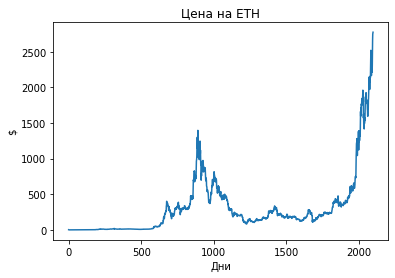

In [9]:
plt.plot(data['price'])
plt.title("Цена на ETH")
plt.xlabel('Дни')
plt.ylabel('$')

plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2088    2240.189216
2089    2229.907142
2090    2195.177215
2091    2111.383055
2092    2074.344591
2093    2044.699930
2094    2003.316305
2095    1972.224734
2096    1934.547334
2097    1895.315178
Name: predicted_mean, dtype: float64


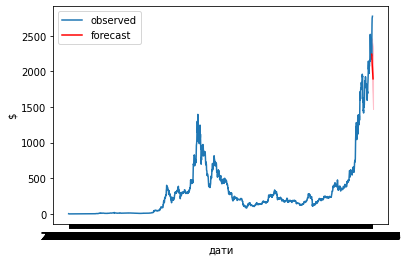

In [10]:
# data = data[['date','coin_id','cmc_rank','market_cap','price']]

model = SARIMAX(data['price'], order=(1, 0, 1), exog=data['volume_24h'])

results = model.fit()

# Generate predictions
dynamic_forecast = results.get_prediction(start=-10, dynamic=True)

# Extract prediction mean
dynamic_mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower price']
upper_limits = confidence_intervals.loc[:,'upper price']

# Print best estimate predictions
print(dynamic_mean_forecast)

# Plot the ETH data
plt.plot(data.date, data.price, label='observed')

# Plot your mean forecast
plt.plot(dynamic_mean_forecast.index, dynamic_mean_forecast, color='r', label='forecast')

# Shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
         upper_limits, color='pink')

# Set labels, legends and show plot
plt.xlabel('дати')
plt.ylabel('$')
plt.legend()
plt.show()

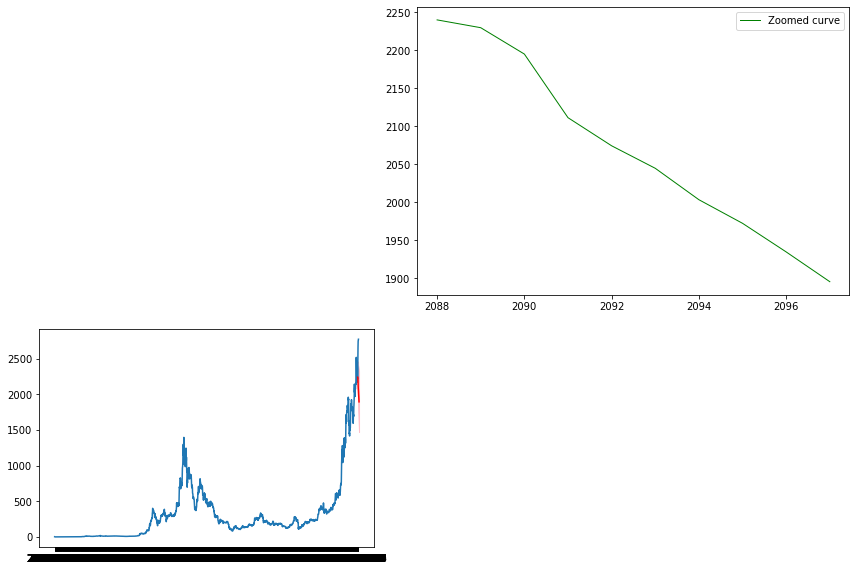

In [11]:
plt.plot(data.date, data.price, label='observed')
plt.plot(dynamic_mean_forecast.index,
         dynamic_mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

axes = plt.axes([1, 1, 1, 1])
axes.plot(dynamic_mean_forecast.index, dynamic_mean_forecast, c='green', lw=1, label="Zoomed curve")
axes.legend()
plt.show()

We take the forecast and if the first value is lower than the last value, we expect the price to rise, so the algorythm suggests to BUY once. If this repeats a couple of days, the algorythm will be buying every day.
However, if the first value is higher than the last one, we expect the price to be be lower, so the algorythm suggests to SELL everything which was bought so far.
In the beginning of the algorythm there should be "bought = 0". As it is still under construction.

In [24]:
bought = 0

if dynamic_mean_forecast.values[-1] > dynamic_mean_forecast.values[1]:
    print("BUY_1")
    bought = 1
elif dynamic_mean_forecast.values[-1] < dynamic_mean_forecast.values[1] and bought == 1:
    print("SELL_All")
    bought = 0